## Categorizing Clothing with CNN
In this project we explore the use of convolutional neural nets for image classification; our dataset is a collection of 10 different types of clothing / accessories that we'll build a model to categorize. The goal of this notebook is to explore the initial dataset, fit a sequential CNN using keras, understand model parameters by testing their effect on model results, and finally, to evaluate the model's predictions and understand where it falls short. This notebook is 6-part:

1. Data Exploration
2. Convolutional Neural Nets: Exploration
3. Convolutional Neural Nets: Optimization
4. Visualizing Filters
5. Prediction Analysis
6. Conclusion

The comments in this notebook serve to orient the reader around my thought process at each step of the project. For a more in-depth explanation of convolutional neural nets and their applications, see my blog post here.

### 1. Data Exploration & Preprocessing
Here we import the dataset, do some light exploration to understand its attributes, and process the data for feeding into the model. Note that there is a uniform distribution across the 10 categories, and that all three shoe categories seem to contain images that are left-facing (toe pointing left). We will address the latter point in the modeling phase, when we use data augmentation to create more varied versions of these inputs.

Keras - the neural network library we will be using to construct our model - requires input vectors to have an extra dimension which correspond to their channels. Working with gray-scaled data, we only have one channel, so we reshape our train and test images to 28 x 28 x 1 3D matrices. Lastly, we create a validation dataset to evaluate our model's accuracy and watch for over/under-fitting during training.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import time
import random

from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.datasets import mnist, fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

np.random.seed(2)
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


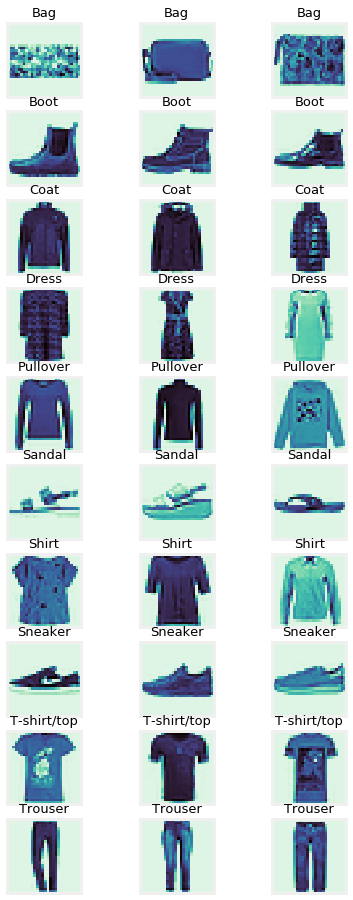

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

categories = {0: 'T-shirt/top',
             1: 'Trouser',
             2: 'Pullover',
             3: 'Dress',
             4: 'Coat',
             5: 'Sandal',
             6: 'Shirt',
             7: 'Sneaker',
             8: 'Bag',
             9: 'Boot'}

#plot random sample of each category
test = list(zip(x_train, [categories[x] for x in y_train]))
test_df = pd.DataFrame(test)

function = lambda obj: obj.loc[np.random.choice(obj.index, 3, False)]
grouped = test_df.groupby(1).apply(function)

fig, axes = plt.subplots(10, 3, figsize=(6,16))
axes = axes.flatten()
for i, image in enumerate(grouped[0]):
    axes[i].imshow(image, cmap='mako_r')
    axes[i].set_title(grouped[1][i], size=13)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

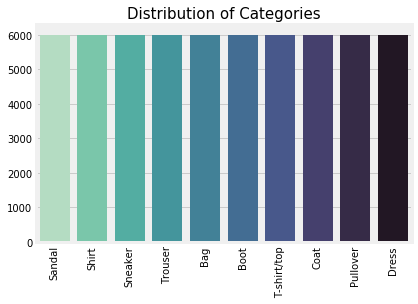

In [3]:
#plot distribution of categories
category_series = pd.Series(y_train).map(categories)
category_counts = category_series.value_counts()
sns.barplot(category_counts.index, category_counts, palette='mako_r')
ticks=plt.xticks(rotation='vertical')
title=plt.title('Distribution of Categories',size=15)

In [4]:
#check for nulls
print(f'Nulls in x_train: {np.isnan(x_train).sum()}')
print(f'Nulls in x_test: {np.isnan(x_test).sum()}')
print(f'Nulls in y_train: {np.isnan(y_train).sum()}')
print(f'Nulls in y_test: {np.isnan(y_test).sum()}')

Nulls in x_train: 0
Nulls in x_test: 0
Nulls in y_train: 0
Nulls in y_test: 0


In [5]:
#scaling to ease computational burden of model; CNN converges faster on [0,1] data than on [0,255]
#note: scaling does not change the way the image renders
x_train_scaled = x_train/255
x_test_scaled = x_test/255

#convert to float32, float64 uses twice as much memory
x_train_scaled_32 = x_train_scaled.astype('float32')
x_test_scaled_32 = x_test_scaled.astype('float32')

#reshape to 4d array with expected input shape of (batch, rows, columns, channels) for keras
#since images are grayscale (1 channel), last dimension is 1
x_train_scaled_shape = x_train_scaled_32.reshape(x_train_scaled_32.shape[0], 28, 28, 1)
x_test_scaled_shape = x_test_scaled_32.reshape(x_test_scaled_32.shape[0], 28, 28, 1)

#convert labels to one-hot-encoded arrays
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

#create validation set
#because we have uniform distribution of y labels, no need to stratify
#random_seed = 2
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train_scaled_shape, y_train_cat, test_size=0.2, random_state=2)


### 2. Convolutional Neural Nets: Exploration
This section explores the effect of tuning CNN parameters, focusing on two hyperparameters in particular - 1) the number of filters in a convolutional layer (I will refer to this as the "filter value") and 2) kernel size. The create_params function creates a dictionary for every combination of these two parameters as indicated by the user; we then loop over this list of dictionaries to create a CNN for each set of parameters and store each model's results in a dataframe for further analysis. Note that for the sake of testing, we fit a simple model here, featuring just one convolutional layer and one dense layer. We will implement a more complex model focused on predictive accuracy in the next section.

After training the models, we look at how their accuracy scores, losses, and model training times compare across the number of filters and kernel sizes. The shaded regions represent error bars, as each filter value was fit with different kernel sizes, and each kernel size was likewise fit with different filter values.

From our pseudo-grid search, we glean the following:
- As expected, the accuracy and loss are improved with a higher number of filters - though as the number of epochs increases, the models with 60 filters perform only marginally better than those with 30.
- Model training time does increase with the number of filters, but not in a linear fashion - models with 5, 10, and 30 filters in the convolutional layer take a similar time to train (avg: 140 seconds), while the model with 60 filters takes longer (avg: 170 seconds) with greater variance. While this difference is not a significant inconvenience, it is useful to note that the 25% increase in model training time only yields a 0.7% increase in model accuracy. 
- We see a similar pattern with kernel size, although now smaller kernel sizes yield greater accuracy / lower loss as they enable the model to detect patterns over smaller receptive fields. 
- Interestingly, model training time does not change as we might expect with kernel size - my initial hypothesis was that the time would increase as the kernel size decreased, since our model will then need to compute a larger number of tensor products when convolving the filter through the input images. Instead, we see that model training time increases up until a certain point - perhaps because the time it takes to calculate the more complex tensor products outweighs the fact that more tensor products are being calculated - but only up to a certain point. At kernel size 28x28, our filters are the same size as our input image, meaning only one tensorproduct is calculated for each input, and model time therefore decreases.
- Across all models, accuracy and loss begins to flatten at 2 epochs, signifying that the marginal improvement of each epoch decreases beyond this point. This is most likely due to the dataset being rather simple - there is not much complexity to be learned beyond two pass-throughs of the model.


In [6]:
def create_params(values_dict: dict) -> list:
    """Create list of dictionaries for every combination of kernel / filter values indicated"""
    (key1, val1), (key2, val2) = values_dict.items()
    return [{key1: x, key2: y} for x in val1 for y in val2]

class CNN:
    """Creates a CNN object, which has methods create_model (to create CNN model) 
    and fit_model (to evaluate and record model results)"""
    def __init__(self, params_dict):
        self.params = params_dict
        self.kernels = params_dict['kernels']
        self.filters = params_dict['filters']
        self.model = self.create_model()
        
    
    def create_model(self):
        '''Simple Sequential model using variations of kernel size and number of filters as indicated by the user'''
        kernels = self.kernels
        filters = self.filters
        model = Sequential([Conv2D(filters=filters, kernel_size=kernels, activation='relu',input_shape=x_train_scaled_shape.shape[1:]),
                            Flatten(),
                            Dense(10, activation='softmax')])
        return model
    

    def fit_model(self, model, epochs=3, batch_size=100):
        start_time = time.time()
        kernels = self.kernels
        filters = self.filters
        model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
        datagen = ImageDataGenerator(rotation_range=10,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1)
    
        model_output = model.fit_generator(datagen.flow(x_train_scaled_shape, y_train_cat, batch_size=batch_size), epochs=epochs,
                                 validation_data=(x_test_scaled_shape, y_test_cat), steps_per_epoch=x_train_scaled_shape.shape[0]/batch_size)
        end_time = time.time()
        model_time = end_time - start_time
        history = pd.DataFrame(model_output.history)
        history['epoch'] = list(range(1, epochs+1))
        history['model_time'] = model_time
        history['filters'] = filters
        history['kernel_size'] = str(kernels)
        return history

In [7]:
testdict = {'kernels':[(5,5),(10,10),(15,15),(28,28)], 'filters':[5,10,30,60]}
params_list = create_params(testdict)

all_results = pd.DataFrame()
for param in params_list:
    cnn = CNN(param)
    model = cnn.create_model()
    model_results = cnn.fit_model(model, epochs=10, batch_size=100)
    all_results = all_results.append(model_results)

Epoch 1/10
600/600 [==============================] - 14s 23ms/step - loss: 0.7970 - accuracy: 0.7124 - val_loss: 0.5790 - val_accuracy: 0.7878
Epoch 2/10
600/600 [==============================] - 14s 23ms/step - loss: 0.6379 - accuracy: 0.7662 - val_loss: 0.5466 - val_accuracy: 0.7939
Epoch 3/10
600/600 [==============================] - 14s 24ms/step - loss: 0.5989 - accuracy: 0.7811 - val_loss: 0.5119 - val_accuracy: 0.8158
Epoch 4/10
600/600 [==============================] - 14s 24ms/step - loss: 0.5719 - accuracy: 0.7931 - val_loss: 0.4804 - val_accuracy: 0.8315
Epoch 5/10
600/600 [==============================] - 14s 24ms/step - loss: 0.5566 - accuracy: 0.7986 - val_loss: 0.4883 - val_accuracy: 0.8291
Epoch 6/10
600/600 [==============================] - 14s 24ms/step - loss: 0.5460 - accuracy: 0.8003 - val_loss: 0.4717 - val_accuracy: 0.8338
Epoch 7/10
600/600 [==============================] - 14s 23ms/step - loss: 0.5366 - accuracy: 0.8062 - val_loss: 0.4525 - val_accuracy:

Epoch 8/10
600/600 [==============================] - 16s 26ms/step - loss: 0.5164 - accuracy: 0.8089 - val_loss: 0.4563 - val_accuracy: 0.8354
Epoch 9/10
600/600 [==============================] - 18s 30ms/step - loss: 0.5083 - accuracy: 0.8123 - val_loss: 0.4549 - val_accuracy: 0.8354
Epoch 10/10
600/600 [==============================] - 18s 31ms/step - loss: 0.5023 - accuracy: 0.8145 - val_loss: 0.4324 - val_accuracy: 0.8455
Epoch 1/10
600/600 [==============================] - 18s 30ms/step - loss: 0.7357 - accuracy: 0.7263 - val_loss: 0.5271 - val_accuracy: 0.8020
Epoch 2/10
600/600 [==============================] - 18s 30ms/step - loss: 0.5648 - accuracy: 0.7897 - val_loss: 0.4746 - val_accuracy: 0.8314
Epoch 3/10
600/600 [==============================] - 18s 30ms/step - loss: 0.5247 - accuracy: 0.8062 - val_loss: 0.4573 - val_accuracy: 0.8333
Epoch 4/10
600/600 [==============================] - 18s 30ms/step - loss: 0.5044 - accuracy: 0.8130 - val_loss: 0.4536 - val_accuracy

600/600 [==============================] - 22s 37ms/step - loss: 0.5223 - accuracy: 0.8045 - val_loss: 0.4454 - val_accuracy: 0.8362
Epoch 5/10
600/600 [==============================] - 23s 38ms/step - loss: 0.5066 - accuracy: 0.8091 - val_loss: 0.4325 - val_accuracy: 0.8456
Epoch 6/10
600/600 [==============================] - 23s 38ms/step - loss: 0.4958 - accuracy: 0.8166 - val_loss: 0.4270 - val_accuracy: 0.8448
Epoch 7/10
600/600 [==============================] - 22s 36ms/step - loss: 0.4806 - accuracy: 0.8205 - val_loss: 0.4291 - val_accuracy: 0.8472
Epoch 8/10
600/600 [==============================] - 23s 38ms/step - loss: 0.4709 - accuracy: 0.8260 - val_loss: 0.4077 - val_accuracy: 0.8532
Epoch 9/10
600/600 [==============================] - 21s 35ms/step - loss: 0.4636 - accuracy: 0.8284 - val_loss: 0.3985 - val_accuracy: 0.8558
Epoch 10/10
600/600 [==============================] - 20s 34ms/step - loss: 0.4609 - accuracy: 0.8289 - val_loss: 0.4133 - val_accuracy: 0.8493
Ep

In [8]:
all_results.head()

,val_loss,val_accuracy,loss,accuracy,epoch,model_time,filters,kernel_size
0,0.579017,0.7878,0.796976,0.712400,1,139.994302,5,"(5, 5)"
1,0.546647,0.7939,0.637927,0.766183,2,139.994302,5,"(5, 5)"
2,0.511948,0.8158,0.598933,0.781050,3,139.994302,5,"(5, 5)"
3,0.480403,0.8315,0.571883,0.793133,4,139.994302,5,"(5, 5)"
4,0.488348,0.8291,0.556595,0.798583,5,139.994302,5,"(5, 5)"


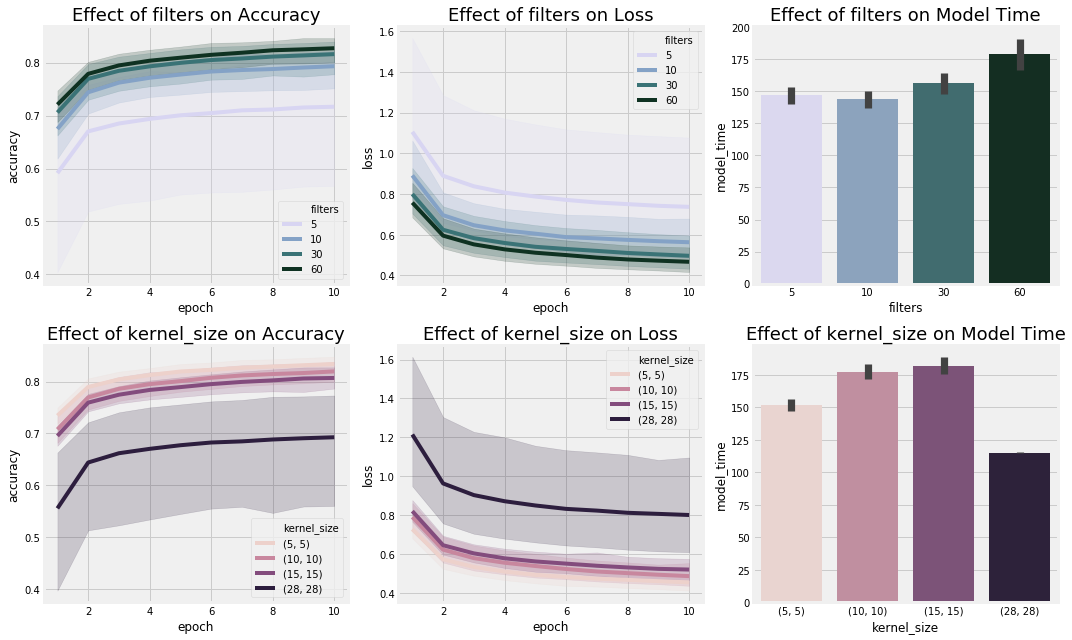

In [9]:
#visualize effects of different parameters on model results and training time
fig, axes = plt.subplots(2,3,figsize=(15,9))
axes = axes.flatten()
for i, metric in enumerate(['filters','kernel_size']):
    sns.lineplot('epoch','accuracy',data=all_results, hue=metric, ax=axes[i*3], palette=sns.cubehelix_palette(4, start=i+11))
    axes[i*3].set_title('Effect of '+metric+' on Accuracy',size=18)
    axes[i*3].legend(loc='lower right')
    sns.lineplot('epoch','loss',data=all_results, hue=metric, ax=axes[i*3+1], palette=sns.cubehelix_palette(4, start=i+11))
    axes[i*3+1].set_title('Effect of '+metric+' on Loss',size=18)
    sns.barplot(metric,'model_time',data=all_results,ax=axes[i*3+2], palette=sns.cubehelix_palette(4, start=i+11))
    axes[i*3+2].set_title('Effect of '+metric+' on Model Time',size=18)
    plt.tight_layout()

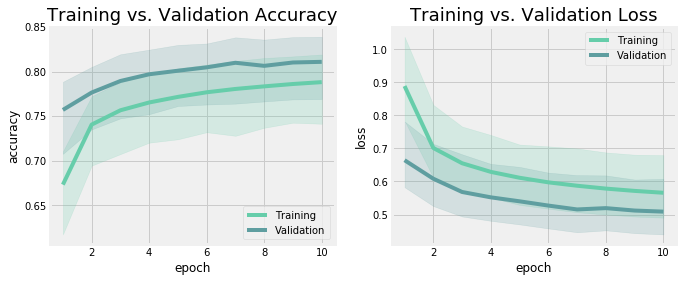

In [10]:
#plot accuracy and loss across all models
fig, axes = plt.subplots(1,2,figsize=(10,4))
sns.lineplot('epoch','accuracy',data=all_results, ax=axes[0], label='Training', color='mediumaquamarine')
sns.lineplot('epoch','val_accuracy',data=all_results, ax=axes[0], label='Validation', color='cadetblue')
axes[0].set_title('Training vs. Validation Accuracy', size=18)
axes[0].set_ylabel('accuracy')
axes[0].legend(loc='lower right')

sns.lineplot('epoch','loss',data=all_results, ax=axes[1], label='Training', color='mediumaquamarine')
sns.lineplot('epoch','val_loss',data=all_results, ax=axes[1], label='Validation', color='cadetblue')
axes[1].set_title('Training vs. Validation Loss', size=18)
axes[1].set_ylabel('loss')
title=axes[1].legend(loc='upper right')

### 3. Convolutional Neural Nets: Optimization
With the more complex model below, our goal is no longer exploration, but accuracy. The model architecture is as follows: (Convolutional Layer + Convolutional Layer + Maxpool Layer + Dropout)*2 + (Flatten + Dense + Dropout + Dense). We test the effect of data augmentation by using Keras' image generator to vary our inputs and bolster our model's ability to generalize to unseen data. Seeing as 30 filters performed only marginally worse than 60 filters, but with significantly less training time, and that 5x5 kernels performed the best with the least amount of training time across all kernel sizes, we'll use 30 filters with 5x5 kernels for each convolutional layer.

This last model achieves a validation accuracy of 92% over 10 epochs - compared to the best model in the previous section (one convolutional layer, 60 filters, kernel size of (5,5)) which achieved 84% accuracy on the validation set, we see the additional layers yield an 8% accuracy improvement. Keep in mind that because this is a rather simple input dataset (only 10 possible outputs, grayscale, uniform distribution of categories, objects are similar sizes) the out-of-the-box accuracy with just one convolutional layer is already pretty high, as observed in the section above. With a more complicated input dataset, we would expect to see a more striking lift in accuracy by adding more convolutional layers.

In [11]:
model_advanced = Sequential([Conv2D(filters=30, kernel_size=(5,5), padding='Same', activation='relu',input_shape=x_train_scaled_shape.shape[1:]),
                   Conv2D(filters=30, kernel_size=(5,5), padding='Same', activation='relu'),
                   MaxPool2D(pool_size=(2,2)),
                   Dropout(0.25),

                   Conv2D(filters=30, kernel_size=(5,5), padding='Same', activation='relu'),
                   Conv2D(filters=30, kernel_size=(5,5), padding='Same', activation='relu'),
                   MaxPool2D(pool_size=(2,2)),
                   Dropout(0.25),

                   Flatten(),
                   Dense(256, activation='relu'),
                   Dropout(0.5),
                   Dense(10, activation='softmax')])

model_advanced.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model_advanced.summary()
epochs=10
batch_size=100

history_no_aug = model_advanced.fit(x_train_split, y_train_split, batch_size=batch_size, epochs=epochs,
                                  validation_data=(x_val_split, y_val_split), verbose=1)

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 28, 28, 30)        780       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 28, 28, 30)        22530     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 30)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 30)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 14, 14, 30)        22530     
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 14, 14, 30)        22530     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 30)        

In [12]:
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=10,
                            zoom_range=0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=False)
datagen.fit(x_train_split)

history_advanced = model_advanced.fit_generator(datagen.flow(x_train_split, y_train_split, batch_size=batch_size),
                                                   epochs=epochs, validation_data=(x_val_split, y_val_split),
                                                   verbose=1, steps_per_epoch=x_train_split.shape[0]//batch_size)

Epoch 1/10
480/480 [==============================] - 114s 237ms/step - loss: 0.4847 - accuracy: 0.8269 - val_loss: 0.2594 - val_accuracy: 0.9062
Epoch 2/10
480/480 [==============================] - 112s 233ms/step - loss: 0.3929 - accuracy: 0.8573 - val_loss: 0.2420 - val_accuracy: 0.9090
Epoch 3/10
480/480 [==============================] - 114s 237ms/step - loss: 0.3706 - accuracy: 0.8635 - val_loss: 0.2295 - val_accuracy: 0.9168
Epoch 4/10
480/480 [==============================] - 110s 228ms/step - loss: 0.3489 - accuracy: 0.8717 - val_loss: 0.2297 - val_accuracy: 0.9150
Epoch 5/10
480/480 [==============================] - 113s 235ms/step - loss: 0.3434 - accuracy: 0.8751 - val_loss: 0.2323 - val_accuracy: 0.9122
Epoch 6/10
480/480 [==============================] - 113s 236ms/step - loss: 0.3344 - accuracy: 0.8767 - val_loss: 0.2405 - val_accuracy: 0.9118
Epoch 7/10
480/480 [==============================] - 115s 239ms/step - loss: 0.3262 - accuracy: 0.8812 - val_loss: 0.2276 -

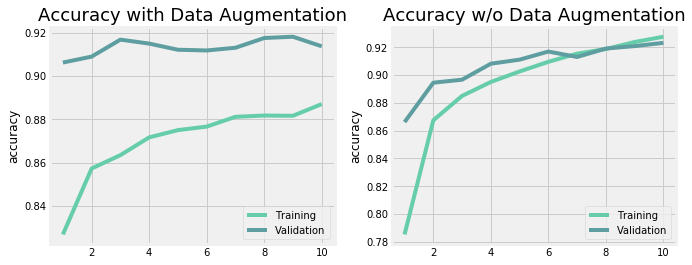

In [13]:
data_aug = pd.DataFrame(history_advanced.history)
no_data_aug = pd.DataFrame(history_no_aug.history)

#plot accuracy and loss across all models
fig, axes = plt.subplots(1,2,figsize=(10,4))
sns.lineplot(range(1,11),'accuracy',data=data_aug, ax=axes[0], label='Training', color='mediumaquamarine')
sns.lineplot(range(1,11),'val_accuracy',data=data_aug, ax=axes[0], label='Validation', color='cadetblue')
axes[0].set_title('Accuracy with Data Augmentation', size=18)
axes[0].set_ylabel('accuracy')
axes[0].legend(loc='lower right')

sns.lineplot(range(1,11),'accuracy',data=no_data_aug, ax=axes[1], label='Training', color='mediumaquamarine')
sns.lineplot(range(1,11),'val_accuracy',data=no_data_aug, ax=axes[1], label='Validation', color='cadetblue')
axes[1].set_title('Accuracy w/o Data Augmentation', size=18)
axes[1].set_ylabel('accuracy')
title=axes[1].legend(loc='lower right')

### 4. Visualizing Filters
I thought it would be an interesting exercise to visualize the outputs from each of the convolutional layers, or feature maps, to further unpack how a CNN works. Here we display the results of three of the convolutional layers in the model from section 3 to look at what the model sees during training. While individual feature maps don't show any discernible patterns or shapes, we gain a sense for how the model "thinks" at each layer of the network. Note that lighter colors represent where each filter was more heavily activated.

In [14]:
layer_dict = dict([(layer.name, layer) for layer in model_advanced.layers])
layer_name = 'conv2d_149'

def visualize_filters(layer_name):
    filter_index = 0

    filters, biases = layer_dict[layer_name].get_weights()

    f_min, f_max = np.amin(filters), np.amax(filters)
    filters = (filters-f_min)/(f_max-f_min)

    n_filters, index = 6,1
    for i in range(n_filters):
        f = filters[:,:,:,i]

        for j in range(3):
            ax=plt.subplot(n_filters, 3, index)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(f[:,:,j], cmap='mako')
            index +=1
    plt.show()

Feature maps from conv2d_34


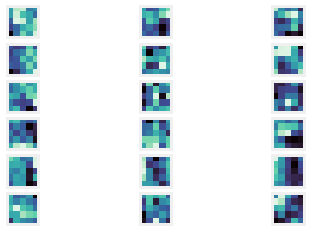

Feature maps from conv2d_35


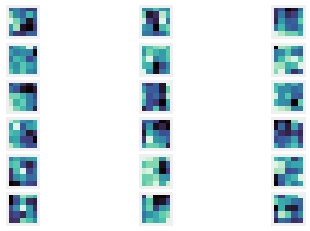

Feature maps from conv2d_36


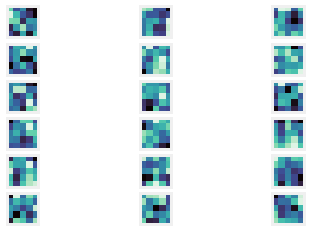

In [15]:
convolutional_layers = [x for x in layer_dict if 'conv' in x]
#second convolutional layer

for layer in convolutional_layers[1:]:
    print(f'Feature maps from {layer}')
    visualize_filters(layer)

### 5. Prediction analysis
And lastly - time to make our predictions. Using the model from section 3 as our final model (with data augmentation), we predict the category for each of our 10,000 test samples. Seeing as there is also a uniform distribution of categories in our test labels (1000 each), we can compare the predicted results to each other without converting to percentages.

We see that sandals, bags, and trousers are the most often correctly predicted, whereas T-shirts, pullovers, and shirts are the most often incorrectly predicted. Makes sense, as the first three categories have relatively distinguishable shapes compared to the last three. In terms of the most common incorrect combinations, shirts are the top mislabled category, most frequently being confused with t-shirts and coats. The last cell in this section looks at a random sample of mislabled test records to investigate further.

In [16]:
pd.Series([categories[y] for y in y_test]).value_counts()

Pullover       1000
Boot           1000
Sneaker        1000
Coat           1000
T-shirt/top    1000
Trouser        1000
Sandal         1000
Bag            1000
Shirt          1000
Dress          1000
dtype: int64

In [19]:
#calculate predictions
predictions = model_advanced.predict(x_test_scaled_shape)
predicted = [np.argmax(x) for x in predictions]
mapped_prediction = [categories[prediction] for prediction in predicted]
mapped_y_test = [categories[y] for y in y_test]
pred_df = pd.DataFrame(zip(predicted, y_test, mapped_prediction, mapped_y_test)).rename(columns={0:'predicted',1:'actual', 2:'predicted_label',3:'actual_label'})

pred_df['correct'] = pred_df['actual'] == pred_df['predicted']
correct = pred_df.groupby('actual_label')[['correct']].sum().sort_values('correct', ascending=False).astype(int)
display(correct)
perc_correct = correct['correct'].sum()/10000
print(f'Correctly predicted {perc_correct}% of test records')

wrong = pred_df[pred_df['correct']==False].groupby(['actual_label','predicted_label'])[['correct']].count().sort_values('correct',ascending=False).rename(columns={'correct':'Count'})
top5_wrong = wrong.nlargest(10, 'Count')
display(top5_wrong)


,correct
actual_label,
Bag,988
Sandal,986
Trouser,986
Boot,966
Sneaker,953
Dress,936
Coat,886
T-shirt/top,831
Pullover,796


Correctly predicted 0.91% of test records


,,Count
actual_label,predicted_label,
T-shirt/top,Shirt,128
Pullover,Shirt,103
Shirt,T-shirt/top,91
Pullover,Coat,79
Shirt,Coat,76
Coat,Shirt,62
Sneaker,Boot,29
Boot,Sneaker,29
Shirt,Pullover,29


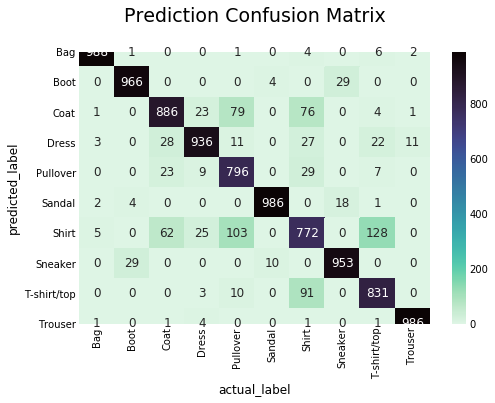

In [20]:
#plot confusion matrix for test samples
#unfortunately top / bottom rows get cut off due to a matplotlib bug
pivot = pred_df.pivot_table('correct',index='predicted_label',columns='actual_label',aggfunc='count').fillna(0)
plt.rcParams['figure.figsize']=(7,5)
sns.heatmap(pivot, cmap='mako_r', annot=True, fmt='.0f', annot_kws={"size": 12})
title=plt.title('Prediction Confusion Matrix', size=19, pad = 30)

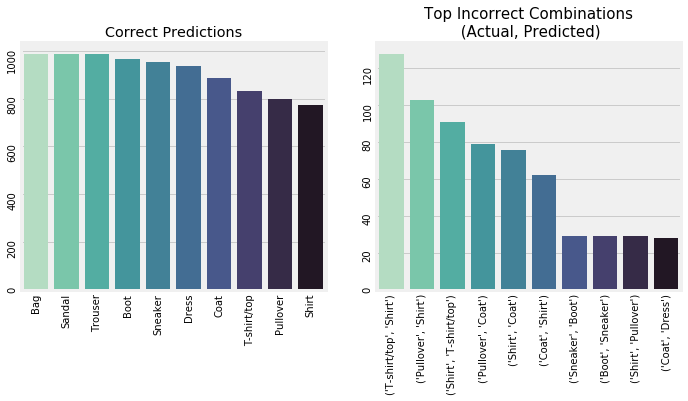

In [21]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))
sns.barplot(correct.index, correct['correct'], ax=axes[0], palette='mako_r')
axes[0].set_title('Correct Predictions')
axes[0].tick_params(labelrotation=90)
axes[0].set_ylabel('')
axes[0].set_xlabel('')

sns.barplot(top5_wrong.index, top5_wrong['Count'], ax=axes[1], palette='mako_r')
axes[1].set_title('Top Incorrect Combinations\n (Actual, Predicted)',size=15)

plt.tight_layout()
axes[1].tick_params(labelrotation=90)
y=axes[1].set_ylabel('')

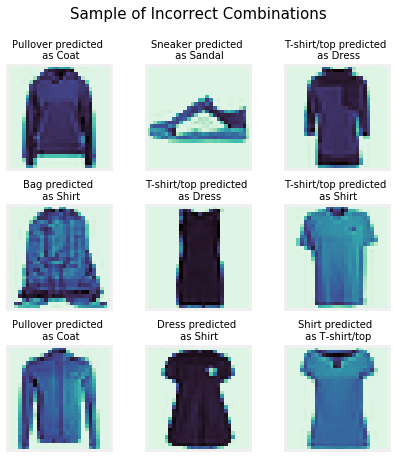

In [29]:
incorrect = pred_df[pred_df['actual_label']!=pred_df['predicted_label']]
incorrect_indices = incorrect.index

sampling_incorrect = random.choices(incorrect_indices, k=9)
fig, axes = plt.subplots(3,3,figsize=(6,6))
axes = axes.flatten()

for i,index in enumerate(sampling_incorrect):
    actual_label = pred_df.iloc[index]['actual_label']
    predicted_label = pred_df.iloc[index]['predicted_label']
    axes[i].imshow(x_test_scaled[index], cmap='mako_r')
    axes[i].set_title(actual_label +' predicted \n as '+predicted_label, size=10)
    axes[i].grid(False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.suptitle('Sample of Incorrect Combinations', y=1.05, size=15)
plt.tight_layout()

### 6. Conclusion

In exploring the effect of kernels and number of filters in Section 3, where our goal was to understand how these parameters affect model results, we were able to better choose these parameters for our model in Section 4, where our goal was model accuracy. Ultimately we were able to correctly predict 92% of our validation set and 90% of our test set using the latter model, with mistakes being made on items that even to the human eye might be categorized incorrectly.

I see two main angles of improvement:
- Running this notebook on GPUs with more epochs for the last model; we see that validation and training accuracy do not converge with only 10 epochs when using data augmentation.
- Add more convolutional layers or more filters to be able to better detect the differences between shirts, t-shirts, and coats, being mindful of the risk of overfitting.

In [ ]:
#questions for neil
#after data augmentation, results are worse? they don't converge either
#visualizing filters - surprised the patterns arent discernible at all
#these projects are largely using packages; not very "pythonic" code. how do i get more practice with the kinds
#of problems that require the use of SWE concepts?
#interesting data visualization libraries?
#how to pipeline updated data?
#should you use test data as validation data? or subset of training data, then test separately